## **Resume Screening (ZAF059)**

### **Resume screening** is the process of reviewing and evaluating resumes submitted by job applicants to determine if they meet the minimum qualifications for the job. It involves a number of steps, including:

* **Reviewing resumes for basic qualifications**: The first step in resume screening involves looking for basic qualifications, such as relevant work experience, education, and skills. This helps to narrow down the pool of applicants and identify those who meet the minimum requirements for the job.

* **Scanning resumes for keywords**: Many employers use applicant tracking systems (ATS) to scan resumes for keywords that match the job description. This helps to identify resumes that are most relevant to the job and filter out those that are not a good fit.

* **Assessing resumes for relevant experience**: Once resumes have been narrowed down, the next step is to assess them for relevant experience. This involves looking at job titles, job duties, and accomplishments to determine if the applicant has the skills and experience necessary for the job.

* **Evaluating resumes for soft skills**: In addition to technical skills and experience, employers also look for soft skills, such as communication, teamwork, and problem-solving. Resumes can provide clues about these skills through the applicant's previous work experience, education, and volunteer work.

* **Comparing resumes to job requirements**: Finally, employers compare resumes to the job requirements to determine which applicants are the best fit for the job. This involves looking at the applicant's qualifications, experience, and skills in relation to the specific requirements of the job.

Overall, resume screening is an important step in the hiring process that helps employers to identify the most qualified candidates for the job.

***
***

## **First Part**

>In here we have trained a ML model on a resume dataset, with which we can tell if a resume matches has what it takes to be shortlisted for our Job Position

In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()  # Choose the kaggle.json file that you downloaded

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abhinavyadav27","key":"a40a65e42ed5139b5e7e3d6e4e32416b"}'}

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/  # Make directory named kaggle and copy kaggle.json file there.
! chmod 600 ~/.kaggle/kaggle.json # Change the permissions of the file.
! kaggle datasets list

ref                                                           title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
salvatorerastelli/spotify-and-youtube                         Spotify and Youtube                              9MB  2023-03-20 15:43:25           2560        105  1.0              
usamabuttar/world-happiness-report-2005-present               World Happiness Report 2005-Present            123KB  2023-03-25 17:38:26            856         25  1.0              
dgoenrique/netflix-movies-and-tv-shows                        Netflix Movies and TV Shows                      2MB  2023-03-13 18:49:00           1747         50  1.0              
rajkumarpandey02/list-of-countries-by-gdp-sector-composition  List of Countries by GDP Sector C

In [7]:
# Download the dataset
!kaggle datasets download -d gauravduttakiit/resume-dataset
!unzip -qq resume-dataset.zip -d ./

  0% 0.00/383k [00:00<?, ?B/s]
100% 383k/383k [00:00<00:00, 99.2MB/s]


In [23]:
#import Library -
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import string
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
# loading dataset

df = pd.read_csv("/content/UpdatedResumeDataSet.csv" ,encoding='utf-8')
df.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 962 entries, 0 to 961
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  962 non-null    object
 1   Resume    962 non-null    object
dtypes: object(2)
memory usage: 15.2+ KB


In [13]:
# checking for null

df.isnull().sum()

Category    0
Resume      0
dtype: int64

In [14]:
# count of each category

category = df['Category'].value_counts().reset_index()
category

,index,Category
0,Java Developer,84
1,Testing,70
2,DevOps Engineer,55
3,Python Developer,48
4,Web Designing,45
5,HR,44
6,Hadoop,42
7,Blockchain,40
8,ETL Developer,40
9,Operations Manager,40


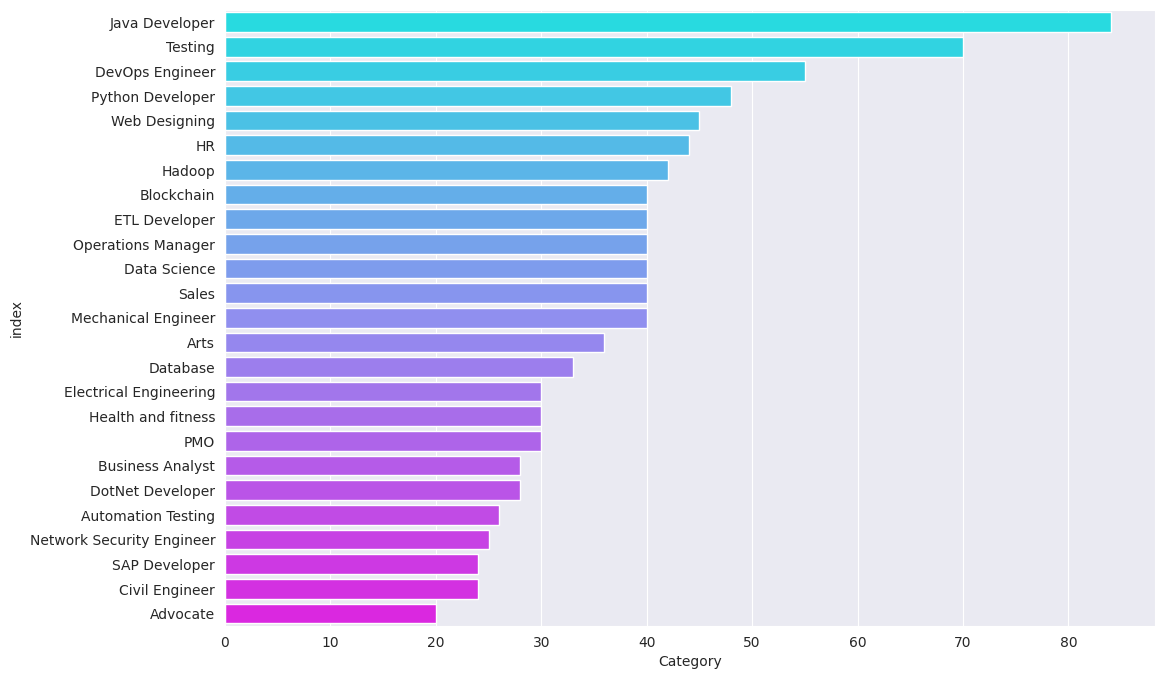

In [15]:
plt.figure(figsize=(12,8))
sns.barplot(x=category['Category'], y=category['index'], palette='cool')
plt.show()

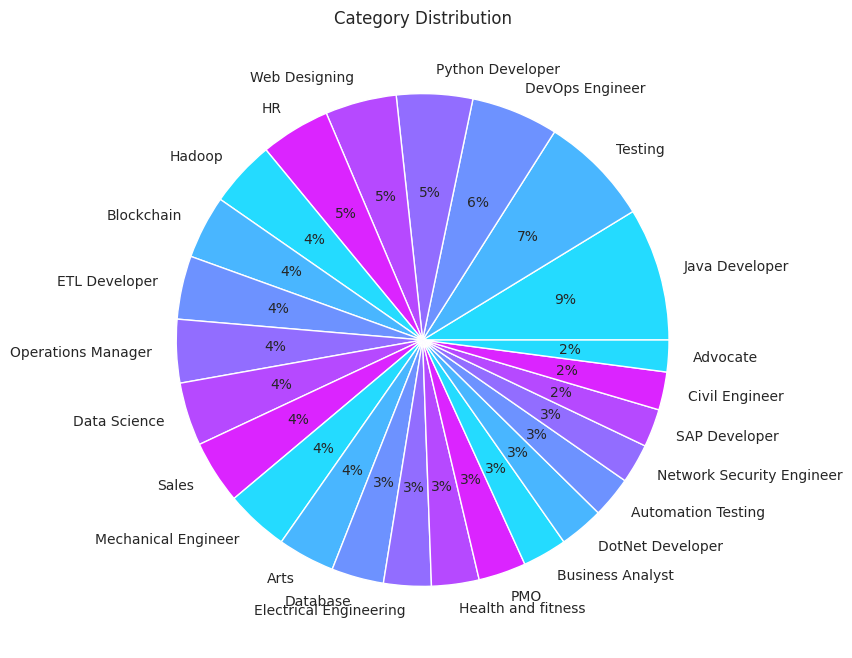

In [16]:
plt.figure(figsize=(12,8))
plt.pie(category['Category'], labels=category['index'],
        colors=sns.color_palette('cool'), autopct='%.0f%%')
plt.title('Category Distribution')
plt.show()

In [17]:
def cleanResume(resumeText):
    resumeText = re.sub('http\S+\s*', ' ', resumeText)  # remove URLs
    resumeText = re.sub('RT|cc', ' ', resumeText)  # remove RT and cc
    resumeText = re.sub('#\S+', '', resumeText)  # remove hashtags
    resumeText = re.sub('@\S+', '  ', resumeText)  # remove mentions
    resumeText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', resumeText)  # remove punctuations
    resumeText = re.sub(r'[^\x00-\x7f]',r' ', resumeText) 
    resumeText = re.sub('\s+', ' ', resumeText)  # remove extra whitespace
    return resumeText

In [18]:
df['cleaned'] = df['Resume'].apply(lambda x:cleanResume(x))
df.head()

,Category,Resume,cleaned
0,Data Science,Skills * Programming Languages: Python (pandas...,Skills Programming Languages Python pandas num...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,Education Details May 2013 to May 2017 B E UIT...
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",Areas of Interest Deep Learning Control System...
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,Skills R Python SAP HANA Tableau SAP HANA SQL ...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",Education Details MCA YMCAUST Faridabad Haryan...


In [19]:
#getting the entire resume text
corpus=" "
for i in range(0,len(df)):
    corpus= corpus+ df["cleaned"][i]

In [21]:
tokenizer = nltk.tokenize.RegexpTokenizer('\w+')
#Tokenizing the text
tokens = tokenizer.tokenize(corpus)
len(tokens)

411913

In [22]:
#now we shall make everything lowercase for uniformity
#to hold the new lower case words
words = []
# Looping through the tokens and make them lower case
for word in tokens:
    words.append(word.lower())
words[0:5]

['skills', 'programming', 'languages', 'python', 'pandas']

In [23]:
# Now encode the data
label = LabelEncoder()
df['new_Category'] = label.fit_transform(df['Category'])
df.head()

,Category,Resume,cleaned,new_Category
0,Data Science,Skills * Programming Languages: Python (pandas...,Skills Programming Languages Python pandas num...,6
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,Education Details May 2013 to May 2017 B E UIT...,6
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",Areas of Interest Deep Learning Control System...,6
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,Skills R Python SAP HANA Tableau SAP HANA SQL ...,6
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",Education Details MCA YMCAUST Faridabad Haryan...,6


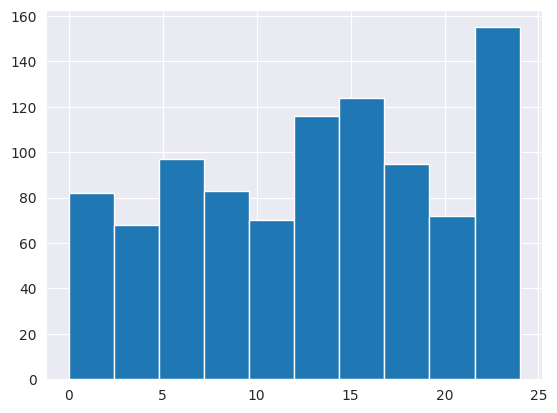

In [24]:
plt.hist(df['new_Category']);

In [25]:
# Vectorizing the cleaned columns
text = df['cleaned'].values
target = df['new_Category'].values
tfidf = TfidfVectorizer(
    sublinear_tf=True,
    stop_words='english',
    max_features=1500)
tfidf.fit(text)
WordFeatures = tfidf.transform(text)

In [26]:
#Save Scaling/Encoding File -
joblib.dump(tfidf,"ResumeFraserModelEncoding.pkl")

WordFeatures.shape

(962, 1500)

In [27]:
target[:10]

array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6])

In [28]:
# Separate train and test data

X_train, X_test, y_train, y_test = train_test_split(WordFeatures, target, random_state=24, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((769, 1500), (193, 1500), (769,), (193,))

In [29]:
# model training

model = OneVsRestClassifier(KNeighborsClassifier())
model.fit(X_train, y_train)

#Save the Model -
joblib.dump(model,"ResumePhrasingModel.pkl")

['ResumePhrasingModel.pkl']

In [30]:
# Prediction
y_pred = model.predict(X_test)
y_pred[:10]

array([22, 10, 16,  1,  6, 15, 10,  9,  6,  1])

In [31]:
# evaluating our model

print(f'---------------------------------\n| Training Accuracy   :- {(model.score(X_train, y_train)*100).round(2)}% |')
print(f'---------------------------------\n| Validation Accuracy :- {(model.score(X_test, y_test)*100).round(2)}% |\n---------------------------------')


---------------------------------
| Training Accuracy   :- 98.96% |
---------------------------------
| Validation Accuracy :- 96.89% |
---------------------------------


In [33]:
# classification report for our model

print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       1.00      1.00      1.00         9
           2       1.00      0.67      0.80         6
           3       1.00      1.00      1.00         9
           4       0.75      1.00      0.86         3
           5       1.00      1.00      1.00         3
           6       1.00      0.57      0.73         7
           7       1.00      1.00      1.00         6
           8       1.00      1.00      1.00        10
           9       1.00      1.00      1.00         6
          10       1.00      1.00      1.00        10
          11       0.80      1.00      0.89         8
          12       1.00      1.00      1.00         6
          13       1.00      1.00      1.00         6
          14       1.00      1.00      1.00         8
          15       1.00      1.00      1.00        16
          16       1.00      1.00      1.00         7
          17       1.00    

In [43]:
label_mapping = dict(zip(label.transform(label.classes_), label.classes_))
label_mapping[0]

'Advocate'

In [45]:
# getting our mappings
label_mapping = dict(zip(label.transform(label.classes_), label.classes_))

# test our model on a sample data
test_sample = df['cleaned'][0] # data scientist resume
prediction = model.predict(tfidf.transform([test_sample]))
label_mapping[float(prediction)]

'Data Science'

In [49]:
#Prediction on User Input -

def suitable_or_not(resume_text, job_position):
  prediction = model.predict(tfidf.transform([resume_text]))
  if label_mapping[float(prediction)] == job_position:
    print(f'Candidate is suitable for the {job_position} Job Position. Consider him for further interview rounds!')
  else:
    print('Candidate is not suitable')

suitable_or_not(df['cleaned'][0], 'Data Science') 

Candidate is suitable for the Data Science Job Position. Consider him for further interview rounds!


## **Second Part**

Extracting features from Resumes/Cover letters, model is trained on spacy with transfomers.

For this we start by, 
* Getting the config files from the official spacy docs
* Annotating our resumes, wherein you can use either https://labelstud.io/ or https://doccano.herokuapp.com/, for the data annotation part. In short, you are annotating all the NER you want from a particular resume.
I have annotated for the following:
>"NER":[
      "College Name",
      "Companies worked at",
      "Degree",
      "Designation",
      "Email Address",
      "Graduation Year",
      "Location",
      "Name",
      "Skills",
      "Years of Experience"
    ]
* After this create dataset as required by spacy i.e. in the '.spacy' format using DocBin
* Follow the docs for the training part and train the model on the .spacy dataset which you have created above.

In [1]:
!pip install -q -U spacy

In [2]:
!pip install -q spacy-transformers

In [5]:
# import locale
# def getpreferredencoding(do_setlocale = True):
#     return "UTF-8"
# locale.getpreferredencoding = getpreferredencoding

In [6]:
!pip install -q pdfminer3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 59.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 89.7 MB/s eta 0:00:00


In [3]:
import spacy
import spacy_transformers
from spacy.tokens import DocBin
from tqdm import tqdm
import json
import random
import gc

from pdfminer3.layout import LAParams, LTTextBox
from pdfminer3.pdfpage import PDFPage
from pdfminer3.pdfinterp import PDFResourceManager
from pdfminer3.pdfinterp import PDFPageInterpreter
from pdfminer3.converter import TextConverter
import io

spacy.__version__

'3.5.1'

In [8]:
!git clone https://github.com/laxmimerit/CV-Parsing-using-Spacy-3.git

Cloning into 'CV-Parsing-using-Spacy-3'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 82 (delta 16), reused 5 (delta 0), pack-reused 0
Unpacking objects: 100% (82/82), 5.33 MiB | 3.26 MiB/s, done.


In [9]:
cv_data = json.load(open('/content/CV-Parsing-using-Spacy-3/data/training/train_data.json', 'r'))
len(cv_data)

200

In [10]:
cv_data[0][1]['entities']

[[1749, 1755, 'Companies worked at'],
 [1696, 1702, 'Companies worked at'],
 [1417, 1423, 'Companies worked at'],
 [1356, 1793, 'Skills'],
 [1209, 1215, 'Companies worked at'],
 [1136, 1247, 'Skills'],
 [928, 932, 'Graduation Year'],
 [858, 889, 'College Name'],
 [821, 856, 'Degree'],
 [787, 791, 'Graduation Year'],
 [744, 750, 'Companies worked at'],
 [722, 742, 'Designation'],
 [658, 664, 'Companies worked at'],
 [640, 656, 'Designation'],
 [574, 580, 'Companies worked at'],
 [555, 572, 'Designation'],
 [470, 493, 'Companies worked at'],
 [444, 468, 'Designation'],
 [308, 314, 'Companies worked at'],
 [234, 240, 'Companies worked at'],
 [175, 198, 'Companies worked at'],
 [93, 136, 'Email Address'],
 [39, 48, 'Location'],
 [13, 37, 'Designation'],
 [0, 12, 'Name']]

In [11]:
!python -m spacy init fill-config /content/CV-Parsing-using-Spacy-3/data/training/base_config.cfg /content/CV-Parsing-using-Spacy-3/data/training/config.cfg

2023-03-31 17:51:19.845953: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
✔ Auto-filled config with all values
✔ Saved config
/content/CV-Parsing-using-Spacy-3/data/training/config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [12]:
def get_spacy_doc(file, data):
  nlp = spacy.blank('en')
  db = DocBin()

  for text, annot in tqdm(data):
    doc = nlp.make_doc(text)
    annot = annot['entities']
    # print(annot)
    # print(type(annot))

    ents = []
    entity_indices = []
    for start, end, label in annot:
      skip_entity = False
      for idx in range(start, end):
        if idx in entity_indices:
          skip_entity = True
          break
      if skip_entity == True:
        continue

      entity_indices.append(list(range(start, end)))
      try:
        span = doc.char_span(start, end, label = label, alignment_mode='strict')
      except:
        pass

      if span is None:
        err_data = str([start, end]) + "  " + str(text)+ '\n'
        #print(err_data)
        try:
          file.write(err_data)
        except:
          err_data = err_data.encode('ascii', 'ignore').decode('ascii')
          file.write(err_data)
      else:
        ents.append(span)

    try:
      doc.ents = ents
      db.add(doc)
    except:
      pass

  return db


In [13]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(cv_data, test_size=0.1)
len(train), len(test)

(180, 20)

In [14]:
file = open('error.txt', 'w')

# train
db = get_spacy_doc(file, train)
db.to_disk('train_data.spacy')

# test
db = get_spacy_doc(file, test)
db.to_disk('test_data.spacy')

file.close()

100%|██████████| 20/20 [00:00<00:00, 123.58it/s]


In [16]:
gc.collect()

413

In [18]:
# training our model

!python -m spacy train /content/CV-Parsing-using-Spacy-3/data/training/config.cfg --output ./output/bert_based_uncased --paths.train ./train_data.spacy --paths.dev ./test_data.spacy --gpu-id 0

2023-03-31 17:54:22.222146: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
✔ Created output directory: output/bert_based_cased
ℹ Saving to output directory: output/bert_based_cased
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
[2023-03-31 17:54:32,031] [INFO] Set up nlp object from config
[2023-03-31 17:54:32,041] [INFO] Pipeline: ['transformer', 'ner']
[2023-03-31 17:54:32,045] [INFO] Created vocabulary
[2023-03-31 17:54:32,046] [INFO] Finished initializing nlp object
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initial

In [5]:
# model testing

def pdf_reader(file):
    resource_manager = PDFResourceManager()
    fake_file_handle = io.StringIO()
    converter = TextConverter(resource_manager, fake_file_handle, laparams=LAParams())
    page_interpreter = PDFPageInterpreter(resource_manager, converter)
    with open(file, 'rb') as fh:
        for page in PDFPage.get_pages(fh,
                                      caching=True,
                                      check_extractable=True):
            page_interpreter.process_page(page)
            print(page)
        text = fake_file_handle.getvalue()

    # close open handles
    converter.close()
    fake_file_handle.close()

    text = ' '.join(text.split()) 

    return text.strip()

nlp = spacy.load('bert_based_uncased')
doc = nlp(pdf_reader('resume.pdf'))

for ent in doc.ents:
  print(f'{ent.label_.upper():{30}}- {ent.text}')

<PDFPage: Resources={'ColorSpace': {'PCSp': <PDFObjRef:4>, 'CSp': /'DeviceRGB', 'CSpg': /'DeviceGray'}, 'ExtGState': {'GSa': <PDFObjRef:3>, 'GState9': <PDFObjRef:9>}, 'Pattern': {}, 'Font': {'F6': <PDFObjRef:6>, 'F7': <PDFObjRef:7>, 'F8': <PDFObjRef:8>}, 'XObject': {'Im10': <PDFObjRef:10>}}, MediaBox=[0, 0, 595, 842]>
NAME                          - Abhinav Yadav
DESIGNATION                   - Data Scientist
COLLEGE NAME                  - Hindu College, University Of Delhi
GRADUATION YEAR               - 2018
COLLEGE NAME                  - St. Mary Academy,
LOCATION                      - NEW DELHI, India abhinav420y.github.io/abhina vportfolio.github.io/ SKILLS Python SQL Data Wrangling Machine Learning Tableau NLP LANGUAGES English Full Professional Proﬁciency Hindi Full Professional Proﬁciency INTERESTS Cooking Chess Customer Segmentation Cinema Performed analysis and unsupervised customer segmentation, using a K-Means from scratch. It performed comparatively to sklearn K-Means. 

### Conclusion:

* The first part is working great since the dataset is pretty good and the simplicity of the problem statement, i.e. clasiifying whether the candidate meet our demand on the basis of a Job Opening.

* The second part, Spacy is used with transformers in order to extract information from a resume based on **Named Entity Recognition(NER)**. The data annotation is a bit hazy and with better annotation and such, we can definitely do much better. It gives us decent result but not a clear enough result. In short it gives us the general idea about the candidate but not accurate enough. It mixes up the data.